In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["NVIDIA_VISIBLE_DEVICES"] = "1"

In [2]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datasets import load_dataset
from torchvision import transforms
import torch
import torch.nn.functional as F
from PIL import Image
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from accelerate import Accelerator, notebook_launcher
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import math
import os
import glob

In [3]:
print('CUDA availability: {}'.format(torch.cuda.is_available()))
print('Num cores: {}'.format(torch.cuda.device_count()))
print('Current Device: {}'.format(torch.cuda.current_device()))

CUDA availability: True
Num cores: 1
Current Device: 0


# Set Configs

In [4]:
@dataclass
class TrainingConfig:
    # image_size = 128  # the generated image resolution
    image_size = 128
#     image_format='RGBA'
    image_format='L'
    channels=1
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 1000
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 25
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    # mixed_precision = 'no'  # requires a GPU
    output_dir = 'model_230402'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

DIR="../images_1_128/"
config = TrainingConfig()

# Create the Dataset

In [5]:
dataset = load_dataset("imagefolder", data_dir=DIR)

Resolving data files:   0%|          | 0/3067 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /mas/u/doorleyr/.cache/huggingface/datasets/imagefolder/default-8b5064cd38c07bfd/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
type(dataset['train'][0]['image'])

PIL.PngImagePlugin.PngImageFile

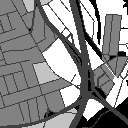

In [9]:
dataset['train'][0]['image']

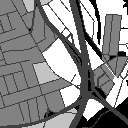

In [7]:
dataset['train'][0]['image'].getchannel(0)

In [10]:
dataset['train'][0]['image'].size

(128, 128)

# Plot a few example images

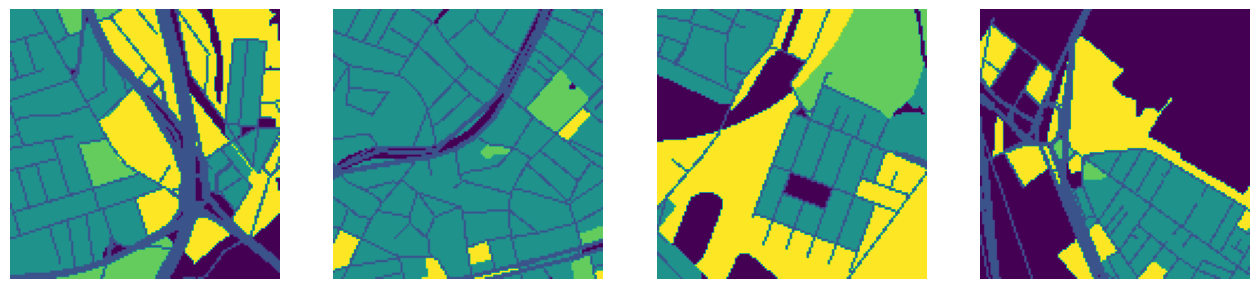

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset['train'][:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

# Apply Transforms

In [12]:
preprocess = transforms.Compose(
    [
        # transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [13]:
def transform(examples):
    images = [preprocess(image.convert(config.image_format)) for image in examples["image"]]
    return {"images": images}

dataset["train"].set_transform(transform)

In [14]:
dataset["train"][0]['images'].shape

torch.Size([1, 128, 128])

In [18]:
# plt.imshow(dataset["train"][0]['images'][0, :, :])
# plt.colorbar()

# Plot transformed images

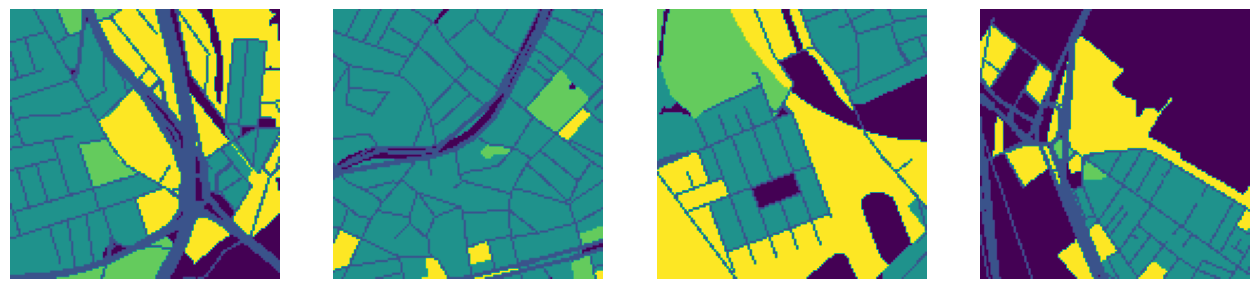

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

# Set up Dataloader

In [19]:
train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=config.train_batch_size, shuffle=True)

# Diffusion Model

In [20]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=config.channels,  # the number of input channels, 3 for RGB images
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 
                         128, 
                        256, 
                        256, 
                        512,
                        512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
         "DownBlock2D", 
         "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
         "UpBlock2D", 
         "UpBlock2D", 
        "UpBlock2D"  
      ),
)

In [21]:
sample_image = dataset["train"][0]['images'].unsqueeze(0)

In [22]:
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 1, 128, 128])


In [23]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 128, 128])


## Define the noise scheduler

In [24]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

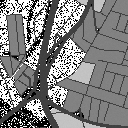

In [38]:
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([0])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)


if config.image_format=='L':
    noised_image=Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0][:,:,0],
                   mode='L')
else:
    noised_image=Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
noised_image

In [39]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1074, grad_fn=<MseLossBackward0>)


## Set up training

In [40]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

 And a cosine learning rate schedule:

In [41]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

# Model evaluation with DDPMPipeline

In [42]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new(config.image_format, size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

# Training Loop

In [43]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        print(epoch)
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            print(logs)
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir) 

# Train Model

In [44]:
%load_ext tensorboard

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.
0


  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 1.1322376728057861, 'lr': 2.0000000000000002e-07, 'step': 0}
{'loss': 1.1135447025299072, 'lr': 4.0000000000000003e-07, 'step': 1}
{'loss': 1.120011806488037, 'lr': 6.000000000000001e-07, 'step': 2}
{'loss': 1.1238605976104736, 'lr': 8.000000000000001e-07, 'step': 3}
{'loss': 1.110870361328125, 'lr': 1.0000000000000002e-06, 'step': 4}
{'loss': 1.1056814193725586, 'lr': 1.2000000000000002e-06, 'step': 5}
{'loss': 1.0854427814483643, 'lr': 1.4000000000000001e-06, 'step': 6}
{'loss': 1.0785642862319946, 'lr': 1.6000000000000001e-06, 'step': 7}
{'loss': 1.075769066810608, 'lr': 1.8e-06, 'step': 8}
{'loss': 1.0475478172302246, 'lr': 2.0000000000000003e-06, 'step': 9}
{'loss': 1.0395848751068115, 'lr': 2.2e-06, 'step': 10}
{'loss': 1.0311951637268066, 'lr': 2.4000000000000003e-06, 'step': 11}
{'loss': 1.0042130947113037, 'lr': 2.6e-06, 'step': 12}
{'loss': 0.9897303581237793, 'lr': 2.8000000000000003e-06, 'step': 13}
{'loss': 0.969270646572113, 'lr': 3e-06, 'step': 14}
{'loss': 0.93

{'loss': 0.045455388724803925, 'lr': 2.6200000000000003e-05, 'step': 130}
{'loss': 0.1119871735572815, 'lr': 2.64e-05, 'step': 131}
{'loss': 0.10719910264015198, 'lr': 2.6600000000000003e-05, 'step': 132}
{'loss': 0.03525008261203766, 'lr': 2.6800000000000004e-05, 'step': 133}
{'loss': 0.07345734536647797, 'lr': 2.7000000000000002e-05, 'step': 134}
{'loss': 0.1269921362400055, 'lr': 2.7200000000000004e-05, 'step': 135}
{'loss': 0.061666764318943024, 'lr': 2.7400000000000002e-05, 'step': 136}
{'loss': 0.08408159762620926, 'lr': 2.7600000000000003e-05, 'step': 137}
{'loss': 0.07418322563171387, 'lr': 2.7800000000000005e-05, 'step': 138}
{'loss': 0.04943443834781647, 'lr': 2.8000000000000003e-05, 'step': 139}
{'loss': 0.1469763219356537, 'lr': 2.8199999999999998e-05, 'step': 140}
{'loss': 0.10106679797172546, 'lr': 2.84e-05, 'step': 141}
{'loss': 0.0374276340007782, 'lr': 2.86e-05, 'step': 142}
{'loss': 0.13158845901489258, 'lr': 2.88e-05, 'step': 143}
{'loss': 0.03807467967271805, 'lr': 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03324146941304207, 'lr': 3.86e-05, 'step': 192}
{'loss': 0.04352173954248428, 'lr': 3.88e-05, 'step': 193}
{'loss': 0.0708305686712265, 'lr': 3.9000000000000006e-05, 'step': 194}
{'loss': 0.1218043714761734, 'lr': 3.9200000000000004e-05, 'step': 195}
{'loss': 0.08054830878973007, 'lr': 3.94e-05, 'step': 196}
{'loss': 0.03648674115538597, 'lr': 3.960000000000001e-05, 'step': 197}
{'loss': 0.07955729961395264, 'lr': 3.9800000000000005e-05, 'step': 198}
{'loss': 0.02706390991806984, 'lr': 4e-05, 'step': 199}
{'loss': 0.07629704475402832, 'lr': 4.02e-05, 'step': 200}
{'loss': 0.04901762306690216, 'lr': 4.0400000000000006e-05, 'step': 201}
{'loss': 0.09232297539710999, 'lr': 4.0600000000000004e-05, 'step': 202}
{'loss': 0.09369450062513351, 'lr': 4.08e-05, 'step': 203}
{'loss': 0.07834567129611969, 'lr': 4.1e-05, 'step': 204}
{'loss': 0.09755135327577591, 'lr': 4.12e-05, 'step': 205}
{'loss': 0.08421781659126282, 'lr': 4.14e-05, 'step': 206}
{'loss': 0.06406770646572113, 'lr': 4.

{'loss': 0.10371015220880508, 'lr': 6.42e-05, 'step': 320}
{'loss': 0.12360847741365433, 'lr': 6.440000000000001e-05, 'step': 321}
{'loss': 0.03248320519924164, 'lr': 6.460000000000001e-05, 'step': 322}
{'loss': 0.029589496552944183, 'lr': 6.48e-05, 'step': 323}
{'loss': 0.10646151006221771, 'lr': 6.500000000000001e-05, 'step': 324}
{'loss': 0.03402599319815636, 'lr': 6.52e-05, 'step': 325}
{'loss': 0.06309905648231506, 'lr': 6.54e-05, 'step': 326}
{'loss': 0.07047615945339203, 'lr': 6.560000000000001e-05, 'step': 327}
{'loss': 0.060823939740657806, 'lr': 6.58e-05, 'step': 328}
{'loss': 0.09357712417840958, 'lr': 6.6e-05, 'step': 329}
{'loss': 0.09504663199186325, 'lr': 6.620000000000001e-05, 'step': 330}
{'loss': 0.049430474638938904, 'lr': 6.64e-05, 'step': 331}
{'loss': 0.04352525621652603, 'lr': 6.66e-05, 'step': 332}
{'loss': 0.0862671434879303, 'lr': 6.680000000000001e-05, 'step': 333}
{'loss': 0.11401787400245667, 'lr': 6.7e-05, 'step': 334}
{'loss': 0.043365657329559326, 'lr': 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.057637982070446014, 'lr': 7.7e-05, 'step': 384}
{'loss': 0.1047913059592247, 'lr': 7.72e-05, 'step': 385}
{'loss': 0.041051432490348816, 'lr': 7.740000000000001e-05, 'step': 386}
{'loss': 0.01656154915690422, 'lr': 7.76e-05, 'step': 387}
{'loss': 0.02185237780213356, 'lr': 7.780000000000001e-05, 'step': 388}
{'loss': 0.1003456562757492, 'lr': 7.800000000000001e-05, 'step': 389}
{'loss': 0.12462851405143738, 'lr': 7.82e-05, 'step': 390}
{'loss': 0.05347520858049393, 'lr': 7.840000000000001e-05, 'step': 391}
{'loss': 0.06280099600553513, 'lr': 7.860000000000001e-05, 'step': 392}
{'loss': 0.04130035638809204, 'lr': 7.88e-05, 'step': 393}
{'loss': 0.05579732358455658, 'lr': 7.900000000000001e-05, 'step': 394}
{'loss': 0.08143538981676102, 'lr': 7.920000000000001e-05, 'step': 395}
{'loss': 0.052338987588882446, 'lr': 7.94e-05, 'step': 396}
{'loss': 0.036570485681295395, 'lr': 7.960000000000001e-05, 'step': 397}
{'loss': 0.01712413690984249, 'lr': 7.98e-05, 'step': 398}
{'loss': 0

{'loss': 0.05764131620526314, 'lr': 9.999999868126277e-05, 'step': 513}
{'loss': 0.030952952802181244, 'lr': 9.99999984861435e-05, 'step': 514}
{'loss': 0.05572030320763588, 'lr': 9.999999827756771e-05, 'step': 515}
{'loss': 0.08287349343299866, 'lr': 9.999999805553541e-05, 'step': 516}
{'loss': 0.061548735946416855, 'lr': 9.999999782004663e-05, 'step': 517}
{'loss': 0.022877003997564316, 'lr': 9.999999757110134e-05, 'step': 518}
{'loss': 0.10715989768505096, 'lr': 9.999999730869956e-05, 'step': 519}
{'loss': 0.028626538813114166, 'lr': 9.999999703284126e-05, 'step': 520}
{'loss': 0.06267067044973373, 'lr': 9.999999674352646e-05, 'step': 521}
{'loss': 0.026811694726347923, 'lr': 9.999999644075516e-05, 'step': 522}
{'loss': 0.07296697050333023, 'lr': 9.999999612452736e-05, 'step': 523}
{'loss': 0.09607856720685959, 'lr': 9.999999579484307e-05, 'step': 524}
{'loss': 0.06441429257392883, 'lr': 9.999999545170227e-05, 'step': 525}
{'loss': 0.038336776196956635, 'lr': 9.999999509510497e-05, 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03807109594345093, 'lr': 9.999996010820395e-05, 'step': 576}
{'loss': 0.04527047276496887, 'lr': 9.999995906532529e-05, 'step': 577}
{'loss': 0.06459694355726242, 'lr': 9.999995800899016e-05, 'step': 578}
{'loss': 0.05356242135167122, 'lr': 9.999995693919851e-05, 'step': 579}
{'loss': 0.068261057138443, 'lr': 9.999995585595038e-05, 'step': 580}
{'loss': 0.10407507419586182, 'lr': 9.999995475924577e-05, 'step': 581}
{'loss': 0.04166819155216217, 'lr': 9.999995364908466e-05, 'step': 582}
{'loss': 0.0814853236079216, 'lr': 9.999995252546706e-05, 'step': 583}
{'loss': 0.03984001278877258, 'lr': 9.999995138839298e-05, 'step': 584}
{'loss': 0.016949478536844254, 'lr': 9.99999502378624e-05, 'step': 585}
{'loss': 0.05387713760137558, 'lr': 9.999994907387533e-05, 'step': 586}
{'loss': 0.0319678857922554, 'lr': 9.999994789643177e-05, 'step': 587}
{'loss': 0.057598717510700226, 'lr': 9.999994670553172e-05, 'step': 588}
{'loss': 0.06224560737609863, 'lr': 9.99999455011752e-05, 'step': 5

{'loss': 0.054328687489032745, 'lr': 9.999975454686885e-05, 'step': 690}
{'loss': 0.07122387737035751, 'lr': 9.999975196995289e-05, 'step': 691}
{'loss': 0.023699726909399033, 'lr': 9.999974937958046e-05, 'step': 692}
{'loss': 0.06307321786880493, 'lr': 9.999974677575163e-05, 'step': 693}
{'loss': 0.04443801939487457, 'lr': 9.999974415846636e-05, 'step': 694}
{'loss': 0.04591396450996399, 'lr': 9.999974152772464e-05, 'step': 695}
{'loss': 0.0294273030012846, 'lr': 9.99997388835265e-05, 'step': 696}
{'loss': 0.07183228433132172, 'lr': 9.999973622587194e-05, 'step': 697}
{'loss': 0.09533898532390594, 'lr': 9.999973355476092e-05, 'step': 698}
{'loss': 0.07161127030849457, 'lr': 9.999973087019348e-05, 'step': 699}
{'loss': 0.037739723920822144, 'lr': 9.999972817216963e-05, 'step': 700}
{'loss': 0.03811492770910263, 'lr': 9.999972546068931e-05, 'step': 701}
{'loss': 0.062264230102300644, 'lr': 9.99997227357526e-05, 'step': 702}
{'loss': 0.04589304327964783, 'lr': 9.999971999735945e-05, 'ste

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.0471501462161541, 'lr': 9.999951313780512e-05, 'step': 768}
{'loss': 0.060293473303318024, 'lr': 9.999950951128954e-05, 'step': 769}
{'loss': 0.06059945374727249, 'lr': 9.999950587131759e-05, 'step': 770}
{'loss': 0.03596533089876175, 'lr': 9.999950221788927e-05, 'step': 771}
{'loss': 0.07182352989912033, 'lr': 9.999949855100457e-05, 'step': 772}
{'loss': 0.05168894678354263, 'lr': 9.999949487066351e-05, 'step': 773}
{'loss': 0.0365387499332428, 'lr': 9.99994911768661e-05, 'step': 774}
{'loss': 0.07875615358352661, 'lr': 9.999948746961231e-05, 'step': 775}
{'loss': 0.06419054418802261, 'lr': 9.999948374890216e-05, 'step': 776}
{'loss': 0.031244371086359024, 'lr': 9.999948001473563e-05, 'step': 777}
{'loss': 0.028100784868001938, 'lr': 9.999947626711276e-05, 'step': 778}
{'loss': 0.04595142602920532, 'lr': 9.999947250603352e-05, 'step': 779}
{'loss': 0.0565890334546566, 'lr': 9.999946873149791e-05, 'step': 780}
{'loss': 0.03279922902584076, 'lr': 9.999946494350597e-05, 'step'

{'loss': 0.05332545191049576, 'lr': 9.999901304280685e-05, 'step': 882}
{'loss': 0.027480976656079292, 'lr': 9.999900788227223e-05, 'step': 883}
{'loss': 0.0567903071641922, 'lr': 9.999900270828137e-05, 'step': 884}
{'loss': 0.08895304799079895, 'lr': 9.999899752083429e-05, 'step': 885}
{'loss': 0.05184514820575714, 'lr': 9.999899231993095e-05, 'step': 886}
{'loss': 0.02841819077730179, 'lr': 9.99989871055714e-05, 'step': 887}
{'loss': 0.04503008723258972, 'lr': 9.99989818777556e-05, 'step': 888}
{'loss': 0.08113595843315125, 'lr': 9.999897663648359e-05, 'step': 889}
{'loss': 0.04135734587907791, 'lr': 9.999897138175533e-05, 'step': 890}
{'loss': 0.08540229499340057, 'lr': 9.999896611357087e-05, 'step': 891}
{'loss': 0.0204571895301342, 'lr': 9.999896083193019e-05, 'step': 892}
{'loss': 0.05326005816459656, 'lr': 9.999895553683327e-05, 'step': 893}
{'loss': 0.07301744818687439, 'lr': 9.999895022828012e-05, 'step': 894}
{'loss': 0.02599642425775528, 'lr': 9.999894490627077e-05, 'step': 

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03304918855428696, 'lr': 9.999857011214228e-05, 'step': 960}
{'loss': 0.039290666580200195, 'lr': 9.999856390202576e-05, 'step': 961}
{'loss': 0.06023464351892471, 'lr': 9.999855767845311e-05, 'step': 962}
{'loss': 0.034867752343416214, 'lr': 9.999855144142436e-05, 'step': 963}
{'loss': 0.03480607271194458, 'lr': 9.999854519093949e-05, 'step': 964}
{'loss': 0.02577083557844162, 'lr': 9.999853892699851e-05, 'step': 965}
{'loss': 0.04208497703075409, 'lr': 9.999853264960141e-05, 'step': 966}
{'loss': 0.033707402646541595, 'lr': 9.999852635874821e-05, 'step': 967}
{'loss': 0.060804154723882675, 'lr': 9.99985200544389e-05, 'step': 968}
{'loss': 0.0230459775775671, 'lr': 9.999851373667351e-05, 'step': 969}
{'loss': 0.011835730634629726, 'lr': 9.999850740545198e-05, 'step': 970}
{'loss': 0.03277416527271271, 'lr': 9.999850106077437e-05, 'step': 971}
{'loss': 0.04723756015300751, 'lr': 9.999849470264067e-05, 'step': 972}
{'loss': 0.042973313480615616, 'lr': 9.999848833105085e-05, '

{'loss': 0.03489171341061592, 'lr': 9.99977832190886e-05, 'step': 1073}
{'loss': 0.06148282438516617, 'lr': 9.999777548844242e-05, 'step': 1074}
{'loss': 0.02322811260819435, 'lr': 9.999776774434034e-05, 'step': 1075}
{'loss': 0.05174341797828674, 'lr': 9.999775998678235e-05, 'step': 1076}
{'loss': 0.05252169072628021, 'lr': 9.999775221576847e-05, 'step': 1077}
{'loss': 0.02977374754846096, 'lr': 9.999774443129868e-05, 'step': 1078}
{'loss': 0.037669308483600616, 'lr': 9.999773663337302e-05, 'step': 1079}
{'loss': 0.06473081558942795, 'lr': 9.999772882199144e-05, 'step': 1080}
{'loss': 0.02852356992661953, 'lr': 9.999772099715399e-05, 'step': 1081}
{'loss': 0.01854025572538376, 'lr': 9.999771315886063e-05, 'step': 1082}
{'loss': 0.055680714547634125, 'lr': 9.999770530711139e-05, 'step': 1083}
{'loss': 0.03819286823272705, 'lr': 9.999769744190628e-05, 'step': 1084}
{'loss': 0.035683464258909225, 'lr': 9.999768956324526e-05, 'step': 1085}
{'loss': 0.0405283197760582, 'lr': 9.999768167112

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.04769038036465645, 'lr': 9.99971310405714e-05, 'step': 1152}
{'loss': 0.030532609671354294, 'lr': 9.999712224691554e-05, 'step': 1153}
{'loss': 0.055290088057518005, 'lr': 9.999711343980394e-05, 'step': 1154}
{'loss': 0.031136207282543182, 'lr': 9.999710461923663e-05, 'step': 1155}
{'loss': 0.03952206298708916, 'lr': 9.99970957852136e-05, 'step': 1156}
{'loss': 0.04743122309446335, 'lr': 9.999708693773481e-05, 'step': 1157}
{'loss': 0.05345941334962845, 'lr': 9.999707807680034e-05, 'step': 1158}
{'loss': 0.0396154411137104, 'lr': 9.999706920241014e-05, 'step': 1159}
{'loss': 0.02547387406229973, 'lr': 9.999706031456424e-05, 'step': 1160}
{'loss': 0.043853841722011566, 'lr': 9.999705141326262e-05, 'step': 1161}
{'loss': 0.03901023417711258, 'lr': 9.999704249850528e-05, 'step': 1162}
{'loss': 0.03356936573982239, 'lr': 9.999703357029224e-05, 'step': 1163}
{'loss': 0.06467404961585999, 'lr': 9.99970246286235e-05, 'step': 1164}
{'loss': 0.028752179816365242, 'lr': 9.999701567349

{'loss': 0.02930547669529915, 'lr': 9.999606251087264e-05, 'step': 1264}
{'loss': 0.026081973686814308, 'lr': 9.999605221019081e-05, 'step': 1265}
{'loss': 0.04008106514811516, 'lr': 9.999604189605354e-05, 'step': 1266}
{'loss': 0.02826741524040699, 'lr': 9.999603156846083e-05, 'step': 1267}
{'loss': 0.053862135857343674, 'lr': 9.99960212274127e-05, 'step': 1268}
{'loss': 0.035208649933338165, 'lr': 9.999601087290911e-05, 'step': 1269}
{'loss': 0.021877337247133255, 'lr': 9.999600050495011e-05, 'step': 1270}
{'loss': 0.03276897594332695, 'lr': 9.999599012353568e-05, 'step': 1271}
{'loss': 0.026847463101148605, 'lr': 9.999597972866584e-05, 'step': 1272}
{'loss': 0.0697832852602005, 'lr': 9.999596932034057e-05, 'step': 1273}
{'loss': 0.03456701710820198, 'lr': 9.999595889855986e-05, 'step': 1274}
{'loss': 0.0743241161108017, 'lr': 9.999594846332376e-05, 'step': 1275}
{'loss': 0.03618983179330826, 'lr': 9.999593801463226e-05, 'step': 1276}
{'loss': 0.06376181542873383, 'lr': 9.99959275524

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.03544338047504425, 'lr': 9.999519593736977e-05, 'step': 1344}
{'loss': 0.04241081327199936, 'lr': 9.999518456026183e-05, 'step': 1345}
{'loss': 0.03414401039481163, 'lr': 9.999517316969865e-05, 'step': 1346}
{'loss': 0.03414151817560196, 'lr': 9.999516176568029e-05, 'step': 1347}
{'loss': 0.037577636539936066, 'lr': 9.999515034820672e-05, 'step': 1348}
{'loss': 0.04297702759504318, 'lr': 9.999513891727797e-05, 'step': 1349}
{'loss': 0.03494209051132202, 'lr': 9.9995127472894e-05, 'step': 1350}
{'loss': 0.04727788269519806, 'lr': 9.999511601505484e-05, 'step': 1351}
{'loss': 0.025769587606191635, 'lr': 9.999510454376051e-05, 'step': 1352}
{'loss': 0.04171283543109894, 'lr': 9.999509305901098e-05, 'step': 1353}
{'loss': 0.03605460375547409, 'lr': 9.999508156080629e-05, 'step': 1354}
{'loss': 0.024627137929201126, 'lr': 9.999507004914641e-05, 'step': 1355}
{'loss': 0.01691683568060398, 'lr': 9.999505852403135e-05, 'step': 1356}
{'loss': 0.03469758480787277, 'lr': 9.999504698546

{'loss': 0.02964911237359047, 'lr': 9.999383806443678e-05, 'step': 1456}
{'loss': 0.01762482337653637, 'lr': 9.999382518036557e-05, 'step': 1457}
{'loss': 0.0341416634619236, 'lr': 9.999381228283955e-05, 'step': 1458}
{'loss': 0.04203176125884056, 'lr': 9.999379937185868e-05, 'step': 1459}
{'loss': 0.01828833669424057, 'lr': 9.999378644742296e-05, 'step': 1460}
{'loss': 0.04071846604347229, 'lr': 9.999377350953243e-05, 'step': 1461}
{'loss': 0.034586064517498016, 'lr': 9.999376055818707e-05, 'step': 1462}
{'loss': 0.05277707800269127, 'lr': 9.999374759338688e-05, 'step': 1463}
{'loss': 0.014308474957942963, 'lr': 9.999373461513188e-05, 'step': 1464}
{'loss': 0.03759388253092766, 'lr': 9.999372162342207e-05, 'step': 1465}
{'loss': 0.037052154541015625, 'lr': 9.999370861825743e-05, 'step': 1466}
{'loss': 0.034588053822517395, 'lr': 9.999369559963798e-05, 'step': 1467}
{'loss': 0.030674414709210396, 'lr': 9.999368256756374e-05, 'step': 1468}
{'loss': 0.025497857481241226, 'lr': 9.99936695

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.04449775815010071, 'lr': 9.999276482173596e-05, 'step': 1536}
{'loss': 0.02346811071038246, 'lr': 9.999275086128878e-05, 'step': 1537}
{'loss': 0.04667283222079277, 'lr': 9.999273688738706e-05, 'step': 1538}
{'loss': 0.07398510724306107, 'lr': 9.999272290003078e-05, 'step': 1539}
{'loss': 0.03577551618218422, 'lr': 9.999270889921997e-05, 'step': 1540}
{'loss': 0.02887999452650547, 'lr': 9.999269488495462e-05, 'step': 1541}
{'loss': 0.030131764709949493, 'lr': 9.999268085723473e-05, 'step': 1542}
{'loss': 0.024346882477402687, 'lr': 9.99926668160603e-05, 'step': 1543}
{'loss': 0.047005750238895416, 'lr': 9.999265276143135e-05, 'step': 1544}
{'loss': 0.03954499587416649, 'lr': 9.999263869334786e-05, 'step': 1545}
{'loss': 0.027795927599072456, 'lr': 9.999262461180987e-05, 'step': 1546}
{'loss': 0.04045817255973816, 'lr': 9.999261051681735e-05, 'step': 1547}
{'loss': 0.03224986046552658, 'lr': 9.999259640837031e-05, 'step': 1548}
{'loss': 0.03770643472671509, 'lr': 9.9992582286

{'loss': 0.041246846318244934, 'lr': 9.999111761904046e-05, 'step': 1648}
{'loss': 0.04898457229137421, 'lr': 9.999110215170773e-05, 'step': 1649}
{'loss': 0.023217007517814636, 'lr': 9.999108667092089e-05, 'step': 1650}
{'loss': 0.02723037451505661, 'lr': 9.999107117667995e-05, 'step': 1651}
{'loss': 0.02519001066684723, 'lr': 9.99910556689849e-05, 'step': 1652}
{'loss': 0.018909573554992676, 'lr': 9.999104014783575e-05, 'step': 1653}
{'loss': 0.028724391013383865, 'lr': 9.999102461323253e-05, 'step': 1654}
{'loss': 0.03510568290948868, 'lr': 9.999100906517522e-05, 'step': 1655}
{'loss': 0.03335222601890564, 'lr': 9.999099350366381e-05, 'step': 1656}
{'loss': 0.03267314285039902, 'lr': 9.999097792869834e-05, 'step': 1657}
{'loss': 0.03701045364141464, 'lr': 9.999096234027878e-05, 'step': 1658}
{'loss': 0.0170303788036108, 'lr': 9.999094673840517e-05, 'step': 1659}
{'loss': 0.03220348060131073, 'lr': 9.999093112307748e-05, 'step': 1660}
{'loss': 0.02048639953136444, 'lr': 9.99909154942

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.02078079618513584, 'lr': 9.998983771778955e-05, 'step': 1728}
{'loss': 0.042955510318279266, 'lr': 9.998982117414166e-05, 'step': 1729}
{'loss': 0.01767679862678051, 'lr': 9.998980461704002e-05, 'step': 1730}
{'loss': 0.028129246085882187, 'lr': 9.99897880464846e-05, 'step': 1731}
{'loss': 0.03066902607679367, 'lr': 9.998977146247544e-05, 'step': 1732}
{'loss': 0.028631018474698067, 'lr': 9.998975486501253e-05, 'step': 1733}
{'loss': 0.027957653626799583, 'lr': 9.998973825409587e-05, 'step': 1734}
{'loss': 0.01761850155889988, 'lr': 9.998972162972548e-05, 'step': 1735}
{'loss': 0.028116118162870407, 'lr': 9.998970499190134e-05, 'step': 1736}
{'loss': 0.035338565707206726, 'lr': 9.998968834062348e-05, 'step': 1737}
{'loss': 0.03182006627321243, 'lr': 9.998967167589189e-05, 'step': 1738}
{'loss': 0.024586638435721397, 'lr': 9.998965499770657e-05, 'step': 1739}
{'loss': 0.04488412290811539, 'lr': 9.998963830606753e-05, 'step': 1740}
{'loss': 0.03318100422620773, 'lr': 9.9989621

{'loss': 0.0501306876540184, 'lr': 9.998790120167376e-05, 'step': 1840}
{'loss': 0.03415630757808685, 'lr': 9.998788315123295e-05, 'step': 1841}
{'loss': 0.023701220750808716, 'lr': 9.99878650873389e-05, 'step': 1842}
{'loss': 0.05163154751062393, 'lr': 9.99878470099916e-05, 'step': 1843}
{'loss': 0.016448266804218292, 'lr': 9.998782891919108e-05, 'step': 1844}
{'loss': 0.02359602600336075, 'lr': 9.998781081493733e-05, 'step': 1845}
{'loss': 0.042293839156627655, 'lr': 9.998779269723036e-05, 'step': 1846}
{'loss': 0.010900923982262611, 'lr': 9.998777456607015e-05, 'step': 1847}
{'loss': 0.031271521002054214, 'lr': 9.998775642145675e-05, 'step': 1848}
{'loss': 0.037517402321100235, 'lr': 9.998773826339015e-05, 'step': 1849}
{'loss': 0.03937245160341263, 'lr': 9.998772009187034e-05, 'step': 1850}
{'loss': 0.024008285254240036, 'lr': 9.998770190689733e-05, 'step': 1851}
{'loss': 0.019017376005649567, 'lr': 9.998768370847112e-05, 'step': 1852}
{'loss': 0.01802445761859417, 'lr': 9.99876654

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's have a look at the final image grid produced by the trained diffusion model:

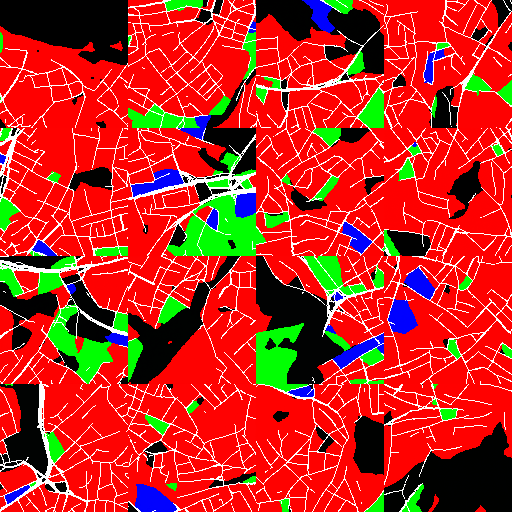

In [32]:
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

# Generate new samples

In [ ]:
pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
images = pipeline(batch_size = config.eval_batch_size,
                  generator=torch.manual_seed(config.seed),).images